<a href="https://colab.research.google.com/github/Jona163/TUMOR_BRAIN/blob/main/TUMOR_BRAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LIBERIAS A IMPORTAR

In [1]:
import os
import glob
import random
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import skimage.io as io
import tensorflow as tf
from tensorflow.keras import layers, optimizers, backend as K
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
)
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display
from google.colab import files

%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
# Lista el contenido dentro de la carpeta 'Colab Notebooks'
os.listdir('/content/drive/MyDrive/Colab Notebooks/TUMOR-BRAIN/Brain_MRI/')

['data.csv',
 'data_mask.csv',
 'weights.hdf5',
 'resnet-50-MRI.json',
 'weights_seg.hdf5',
 'ResUNet-MRI.json',
 'utilities.py',
 '.DS_Store',
 '._TCGA_CS_6667_20011105',
 '._TCGA_DU_8164_19970111',
 '._TCGA_DU_8168_19970503',
 '._TCGA_DU_7300_19910814',
 '._TCGA_HT_7475_19970918',
 '._TCGA_DU_7010_19860307',
 '._TCGA_FG_6688_20020215',
 '._TCGA_DU_8167_19970402',
 '._TCGA_DU_7304_19930325',
 '._TCGA_HT_7684_19950816',
 '._TCGA_DU_5871_19941206',
 '._TCGA_HT_8105_19980826',
 '._TCGA_DU_6401_19831001',
 '._TCGA_FG_6692_20020606',
 '._TCGA_HT_A616_19991226',
 '._.DS_Store',
 '._TCGA_FG_7634_20000128',
 '._TCGA_DU_7306_19930512',
 '._TCGA_DU_A5TP_19970614',
 '._TCGA_HT_8113_19930809',
 '._TCGA_HT_7605_19950916',
 '._TCGA_DU_A5TY_19970709',
 '._TCGA_HT_7860_19960513',
 '._TCGA_HT_8114_19981030',
 '._TCGA_DU_8165_19970205',
 '._data_mask.csv',
 '._TCGA_DU_A5TW_19980228',
 '._TCGA_DU_6400_19830518',
 '._TCGA_HT_7608_19940304',
 '._TCGA_HT_8563_19981209',
 '._TCGA_HT_7884_19980913',
 '._TCGA

In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/TUMOR-BRAIN/Brain_MRI/

/content/drive/MyDrive/Colab Notebooks/TUMOR-BRAIN/Brain_MRI


In [5]:
# Cargamos los puntos faciales clave
brain_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TUMOR-BRAIN/Brain_MRI/data_mask.csv')

In [6]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [7]:
brain_df.head(50)

patient_id                                         image_path  \
0   TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1   TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2   TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3   TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4   TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
5   TCGA_CS_5395_19981004  TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif   
6   TCGA_CS_5395_19981004  TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif   
7   TCGA_CS_5395_19981004  TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif   
8   TCGA_CS_5395_19981004  TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif   
9   TCGA_CS_5395_19981004  TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif   
10  TCGA_CS_5395_19981004  TCGA_CS_6669_20020102/TCGA_CS_6669_20020102_1.tif   
11  TCGA_CS_5395_19981004  TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_1.tif   
12  TCGA_CS_5395_19981004  TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_1.tif   
13  TCGA_CS_5395_19981004  TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_1.tif   
14  TCGA_CS_5395_19981004  TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_1.tif   
15  TCGA_CS_5395_19981004  TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_1.tif   
16  TCGA_CS_5395_19981004  TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_1.tif   
17  TCGA_CS_5395_19981004  TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_1.tif   
18  TCGA_CS_5395_19981004  TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_1.tif   
19  TCGA_CS_5395_19981004  TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_1.tif   
20  TCGA_CS_4944_20010208  TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_1.tif   
21  TCGA_CS_4944_20010208  TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_1.tif   
22  TCGA_CS_4944_20010208  TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_1.tif   
23  TCGA_CS_4944_20010208  TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_1.tif   
24  TCGA_CS_4944_20010208  TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_1.tif   
25  TCGA_CS_4944_20010208  TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_1.tif   
26  TCGA_CS_4944_20010208  TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_1.tif   
27  TCGA_CS_4944_20010208  TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_1.tif   
28  TCGA_CS_4944_20010208  TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_1.tif   
29  TCGA_CS_4944_20010208  TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_1.tif   
30  TCGA_CS_4944_20010208  TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_1.tif   
31  TCGA_CS_4944_20010208  TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_1.tif   
32  TCGA_CS_4944_20010208  TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_1.tif   
33  TCGA_CS_4944_20010208  TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_1.tif   
34  TCGA_CS_4944_20010208  TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_1.tif   
35  TCGA_CS_4944_20010208  TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_1.tif   
36  TCGA_CS_4944_20010208  TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_1.tif   
37  TCGA_CS_4944_20010208  TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_1.tif   
38  TCGA_CS_4944_20010208  TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif   
39  TCGA_CS_4944_20010208  TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif   
40  TCGA_CS_4941_19960909  TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_1.tif   
41  TCGA_CS_4941_19960909  TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_1.tif   
42  TCGA_CS_4941_19960909  TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_1.tif   
43  TCGA_CS_4941_19960909  TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif   
44  TCGA_CS_4941_19960909  TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_1.tif   
45  TCGA_CS_4941_19960909  TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_1.tif   
46  TCGA_CS_4941_19960909  TCGA_DU_8165_19970205/TCGA_DU_8165_19970205_1.tif   
47  TCGA_CS_4941_19960909  TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_1.tif   
48  TCGA_CS_4941_19960909  TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_1.tif   
49  TCGA_CS_494

In [8]:
 brain_df.mask_path[1] #ruta a la imagen MRI

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_mask.tif'

In [9]:
 brain_df.image_path[1] #ruta a la imagen MRI

'TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif'

# MINI RETO #1
¿Tenemos un dataset balanceado?
¿Cuantas muestras estan marcadas como pacientes sano?

In [10]:
brain_df['mask'].value_counts()

mask
0    2556
1    1373
Name: count, dtype: int64

In [11]:
brain_df

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

In [12]:
brain_df['mask'].value_counts().index

Index([0, 1], dtype='int64', name='mask')

In [13]:
# usaremos ploty para hacer un diagrama de barras interactivas
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index, y=brain_df['mask'].value_counts())])
fig.update_traces(marker_color='rgb(0,200,0)', marker_line_color='rgb(0,255,0)',
                  marker_line_width=1.5, opacity=0.6)
fig.show()

In [14]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

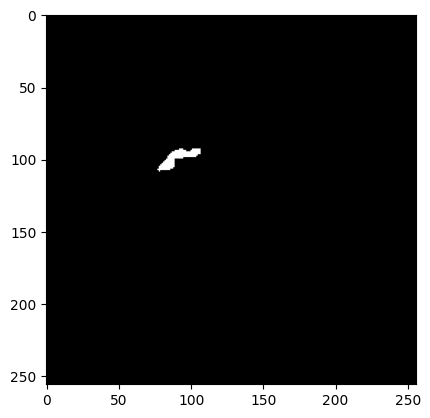

In [15]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

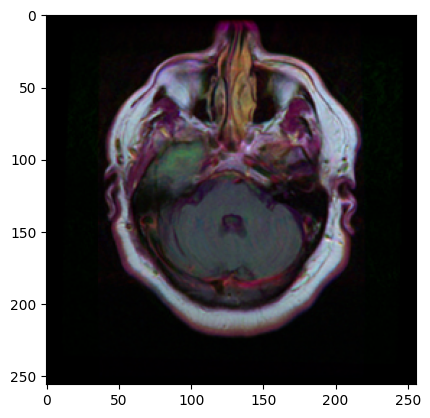

In [16]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [17]:
cv2.imread(brain_df.mask_path[623]).max()

np.uint8(255)

In [18]:
cv2.imread(brain_df.image_path[623]).min()

np.uint8(0)

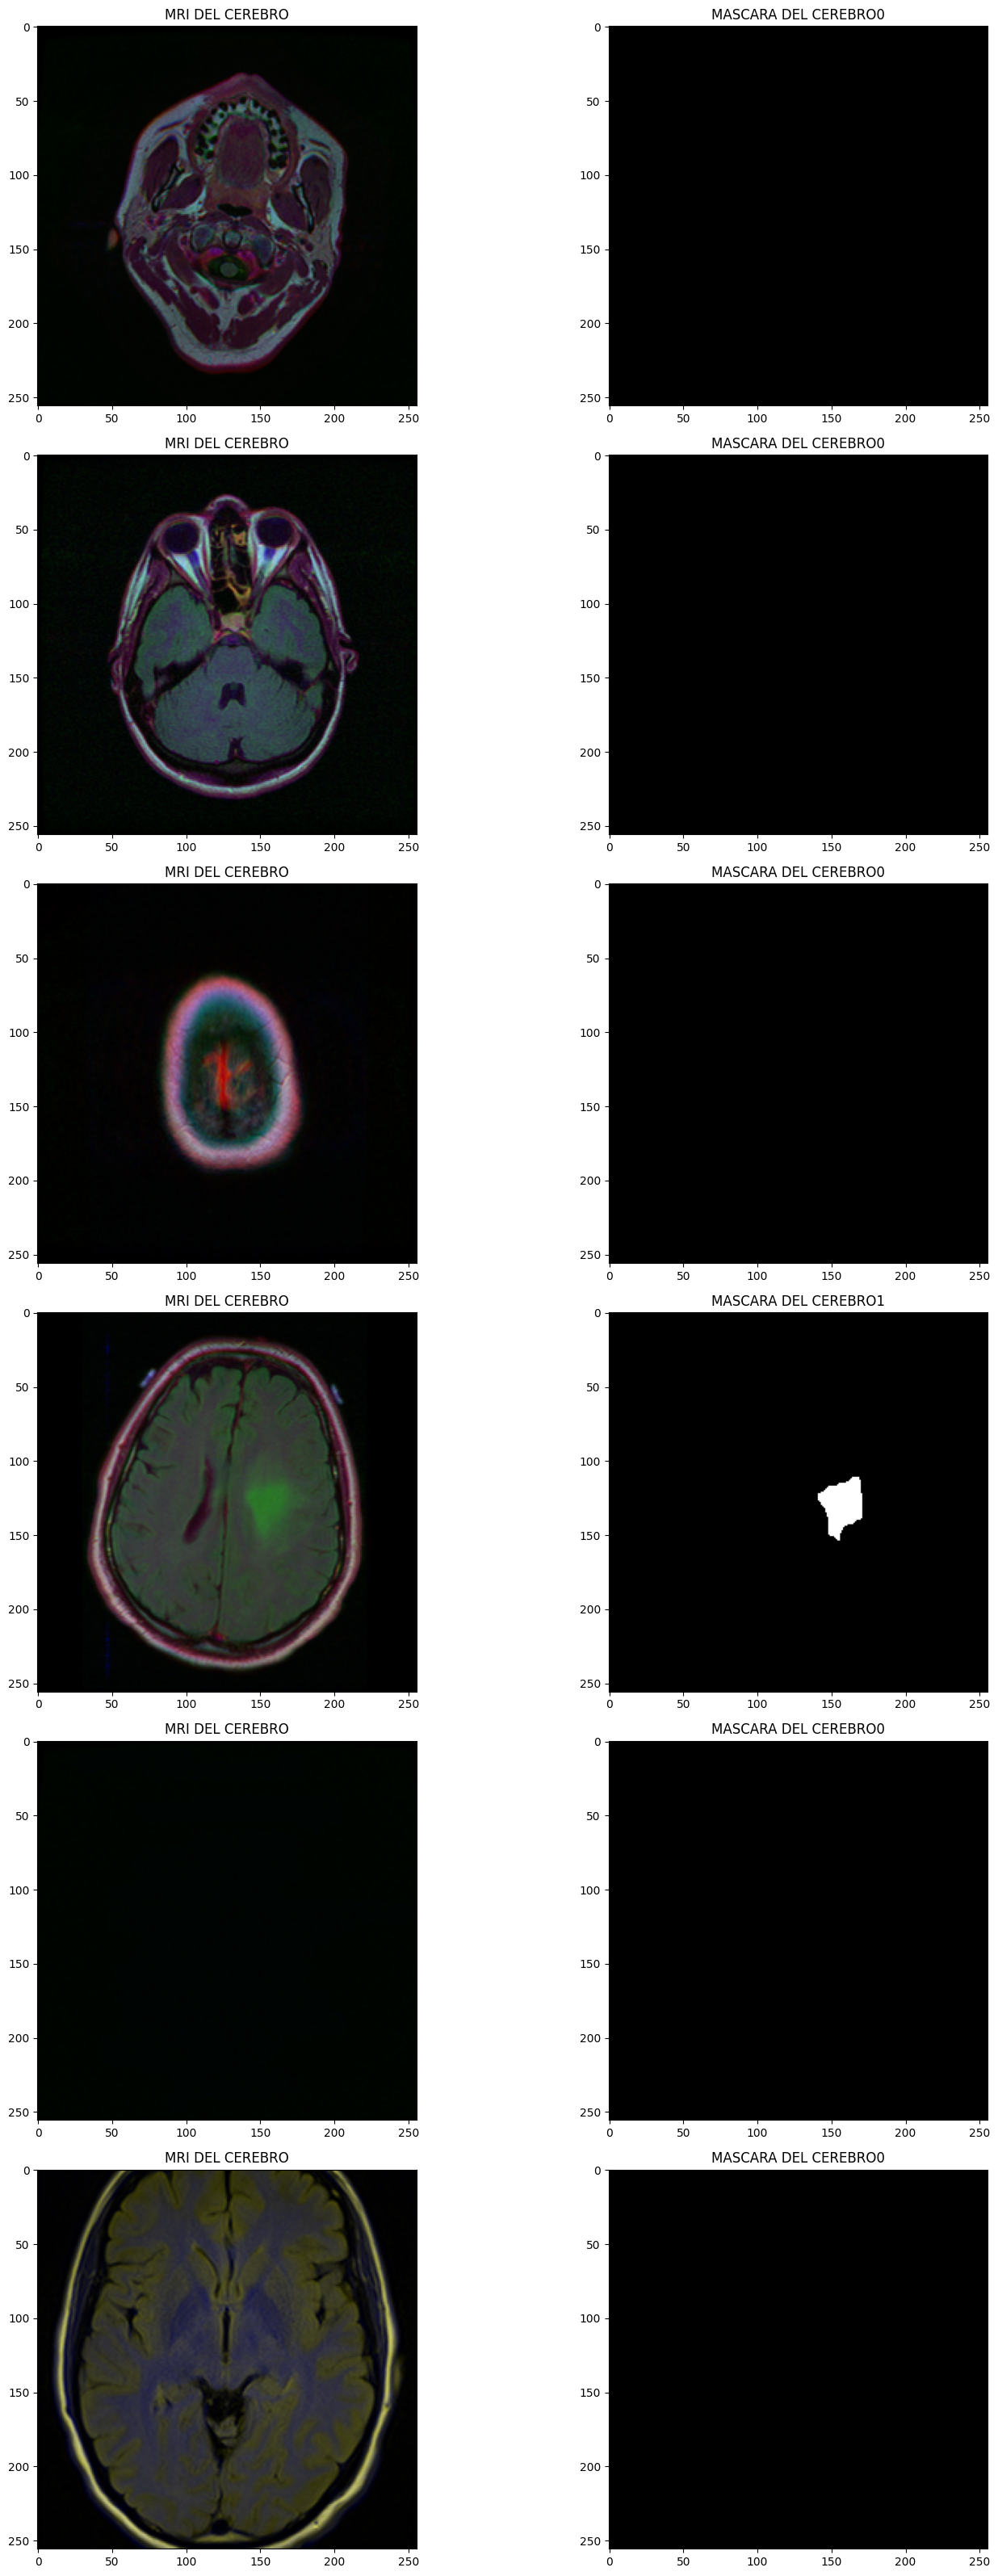

In [19]:
# visualizacion basica  vizualizaremos imagenes (MRI y Mascaras) en el dataset de forma separada.
import random
fig, axs = plt.subplots(6, 2, figsize=(16, 32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df))
  axs[count][0].title.set_text("MRI DEL CEREBRO")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))
  axs[count][1].title.set_text("MASCARA DEL CEREBRO" +str(brain_df['mask'][i]))
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
  count += 1
fig.tight_layout()

MINI RETO 2#
REPRESENTAR ALEATORIAMENTE 12(1) IMAGENES DE MRI SELECCIONADAS ALEATORIAMENTE DE ENTRE LOS PACIENTES ENFERMOS SEGUIDAS DE (2) SU CORRESPONDIENTE MASCARA(3) TANTO LA IMAGEN DE LA MRI JUNTO CON SU MASCARA (DE COLOR ROJO) UNA ENCIMA DE LA OTRA.

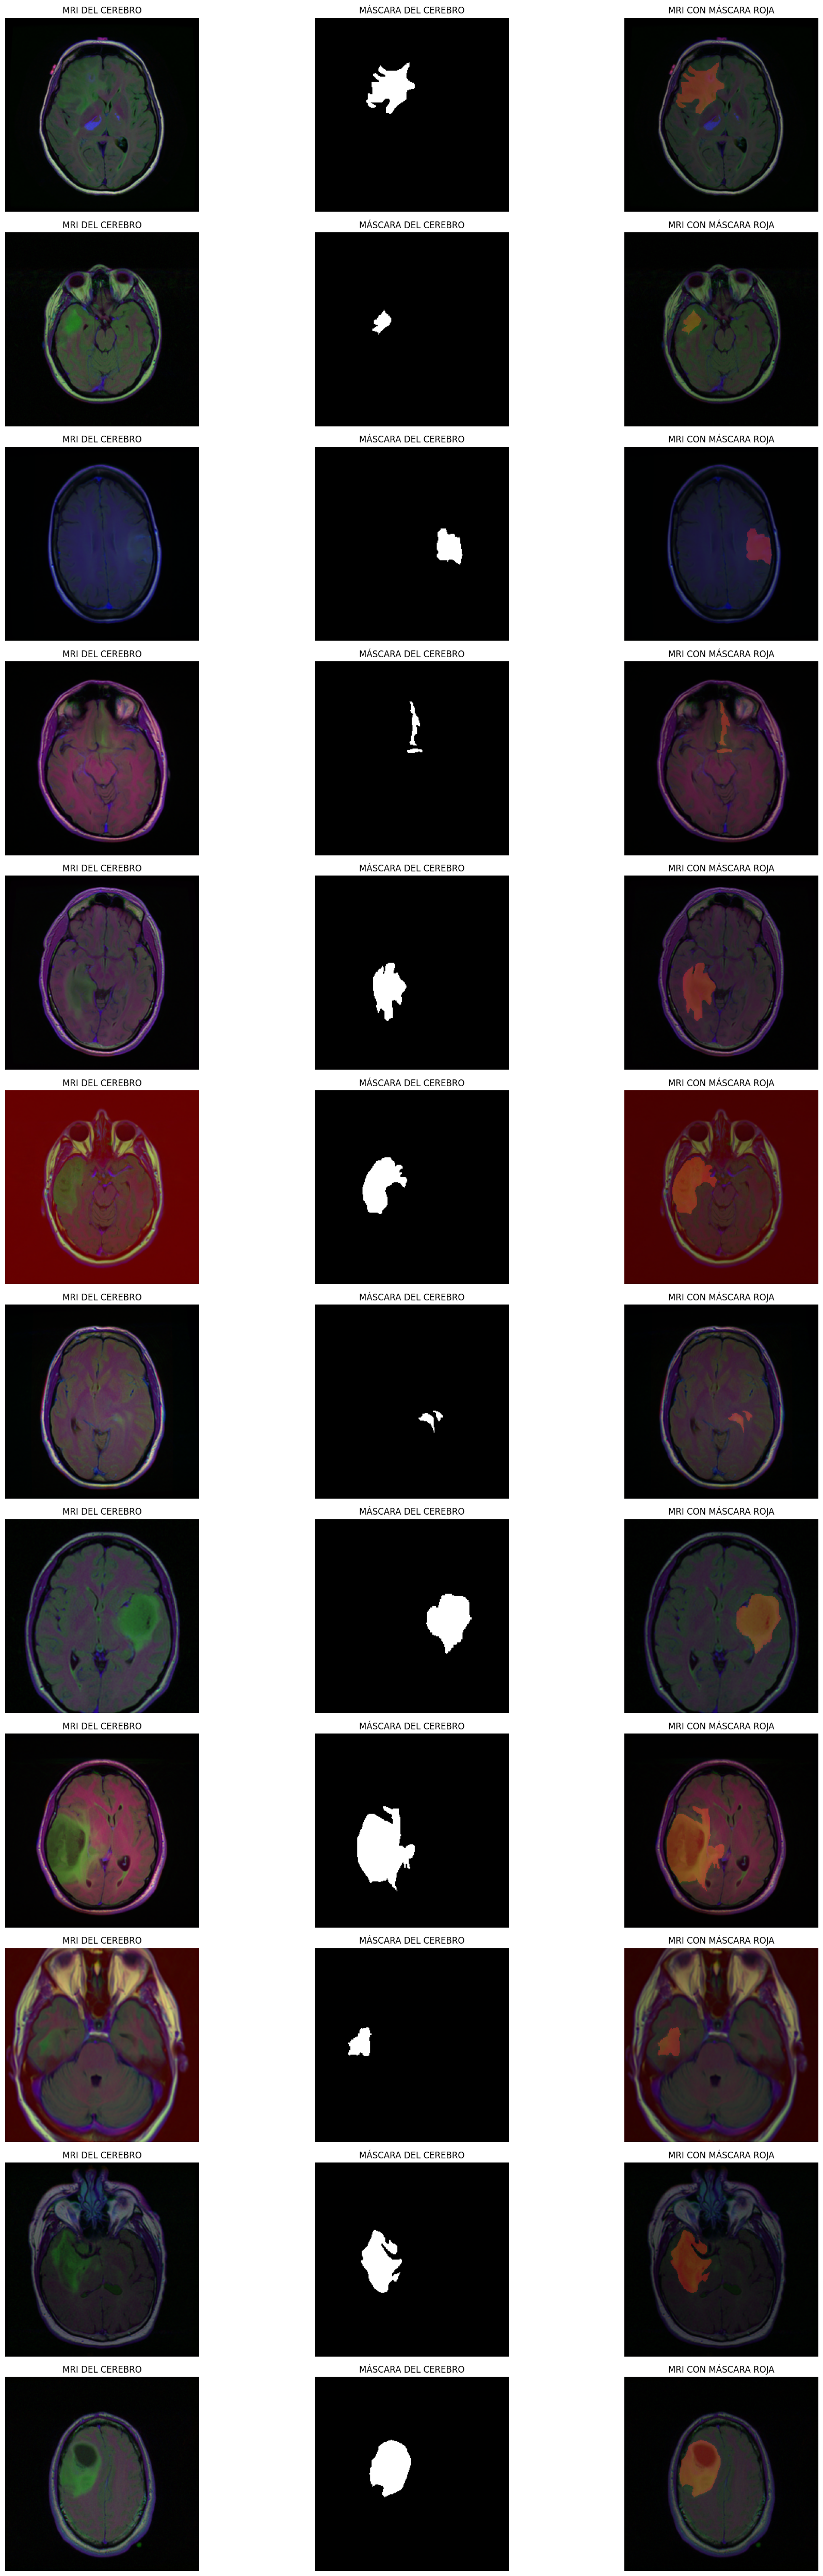

In [20]:
import random

# Filtrar solo imágenes de pacientes enfermos
brain_sick_df = brain_df[brain_df['mask'] == 1]

# Seleccionar 12 imágenes aleatorias de pacientes enfermos
selected_samples = brain_sick_df.sample(n=12, random_state=42)

fig, axs = plt.subplots(12, 3, figsize=(20, 50))

for count, (_, row) in enumerate(selected_samples.iterrows()):
    img = cv2.imread(row.image_path)  # Cargar la imagen MRI
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB

    mask = cv2.imread(row.mask_path, cv2.IMREAD_GRAYSCALE)  # Cargar la máscara en escala de grises

    # Mostrar la imagen original
    axs[count][0].imshow(img)
    axs[count][0].set_title("MRI DEL CEREBRO")
    axs[count][0].axis("off")

    # Mostrar la máscara
    axs[count][1].imshow(mask, cmap='gray')
    axs[count][1].set_title("MÁSCARA DEL CEREBRO")
    axs[count][1].axis("off")

    # Superponer la máscara en rojo sobre la imagen
    mask_colored = np.zeros_like(img)
    mask_colored[:, :, 0] = mask  # Asignar máscara al canal rojo

    overlay = cv2.addWeighted(img, 0.7, mask_colored, 0.3, 0)  # Fusionar imagen y máscara

    axs[count][2].imshow(overlay)
    axs[count][2].set_title("MRI CON MÁSCARA ROJA")
    axs[count][2].axis("off")

fig.tight_layout()
plt.show()


RETO #3:
¿CUAL ES EL RENDIMIENTO DE RESNET EN EL CONJUNTO DE DATOS IMAGENET?
EXPLORA OTRAS ARQUITECTURAS DE RNC COMO ALEXNET Y ENUMERA SU RENDIMIENTO EN COMPARACION CON RESNET (SE REQUIERE EXTERNA)

TAREA #4 ENTENDER LA TEORIA Y LA INTUICION DETRAS DE LAS REDES NEURONALES Y RESNETS CONVOLUCIONALES.

MINI RETO #4
ENUMERE LOS DESAFIOS DEL APRENDIZAJE POR TRASFERENCIA ( SE REQUIERE INVESTIGACION EXTERNA)

TAREA #6 ENTRENAR UN MODELO CLASIFICADOR PARA DETECTAR SI EXISTE TUMOR O NO

In [21]:
# Eliminamos la columna de identificador del paciente
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [22]:
#Convertir los datos  en la columna de mascara a formato de string para el modo categorico en flow_meter_frame
#veras este mensaje de error si comentas la siguiente linea de codigo.
#TypeError: If class_modern"categorical", y_col="mask" columns values
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [23]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [24]:
#Dividir los datos en entrenamiento y testing
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.19)

In [25]:
!pip install keras-Preprocessing

In [26]:
from keras_preprocessing.image import ImageDataGenerator

#creamos un generador de datos que escala los datos de 0 a 1 y haga una division de validacion de 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split= 0.15)

In [27]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    subset='training',
    batch_size=16,
    shuffle=True,
    class_mode='categorical',
    target_size=(256, 256))

valid_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory='./',
    x_col='image_path',
    y_col='mask',
    subset='validation',
    batch_size=16,
    shuffle=True,
    class_mode='categorical',
    target_size=(256, 256))

# creamos un generador de datos para imagenes de prueba
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory='./',
    x_col='image_path',
    y_col='mask',
    batch_size=16,
    shuffle=False,
    class_mode='categorical',
    target_size=(256, 256))


Found 2705 validated image filenames belonging to 2 classes.
Found 477 validated image filenames belonging to 2 classes.
Found 747 validated image filenames belonging to 2 classes.


In [28]:
basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor= Input(shape=(256, 256, 3)))

In [29]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [30]:
# congelar pesos del modelo
for layer in basemodel.layers:
  layer.trainable = False

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout

# Agregamos una cabecera de clasificación al modelo base
head_model = basemodel.output
head_model = AveragePooling2D(pool_size=(4, 4))(head_model)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(256, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(256, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)

# Capa de salida con 2 clases
head_model = Dense(2, activation='softmax', name='output')(head_model)

# Definir el modelo final
model = Model(inputs=basemodel.input, outputs=head_model)


In [32]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,751,426 (98.23 MB)

 Trainable params: 2,163,714 (8.25 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [33]:
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Definir la parada temprana para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardar el mejor modelo basado en la métrica de validación
checkpoint = ModelCheckpoint(filepath='classifier-resnet.h5', monitor='val_loss',
                             mode='min', verbose=1, save_best_only=True)


In [35]:
history = model.fit(train_generator,steps_per_epoch= train_generator.n //16,
                    epochs = 1,validation_data=valid_generator,
                    validation_steps= valid_generator.n //16,
                    callbacks=[early_stopping, checkpoint]
                    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:238: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))



169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5722 - loss: 1.0119
Epoch 1: val_loss improved from inf to 0.60626, saving model to classifier-resnet.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 827s 5s/step - accuracy: 0.5725 - loss: 1.0104 - val_accuracy: 0.6595 - val_loss: 0.6063


In [36]:
model_json = model.to_json()
with open("classifier-resnet.json", "w") as json_file:
    json_file.write(model_json)

In [37]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4, 4))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation='softmax')(headmodel)

model = Model(inputs=basemodel.input, outputs=headmodel)

In [38]:
model.summary()

Model: "functional_1"

TAREA 7: EVALUA EL RENDIMIENTO DEL MODELO ENTRENADO

In [ ]:
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel = json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
test_predict = model.predict(test_generator, steps=test_generator.n // 16, verbose=1)

In [ ]:
test_predict.shape